((< cv2.DMatch 000001E7E6291150>, < cv2.DMatch 000001E7C6C76670>), (< cv2.DMatch 000001E7E6F67950>, < cv2.DMatch 000001E7E6F67910>), (< cv2.DMatch 000001E7E6F67970>, < cv2.DMatch 000001E7E6F67510>), (< cv2.DMatch 000001E7E6F678F0>, < cv2.DMatch 000001E7E6F678D0>), (< cv2.DMatch 000001E7E6F678B0>, < cv2.DMatch 000001E7E6F67890>))


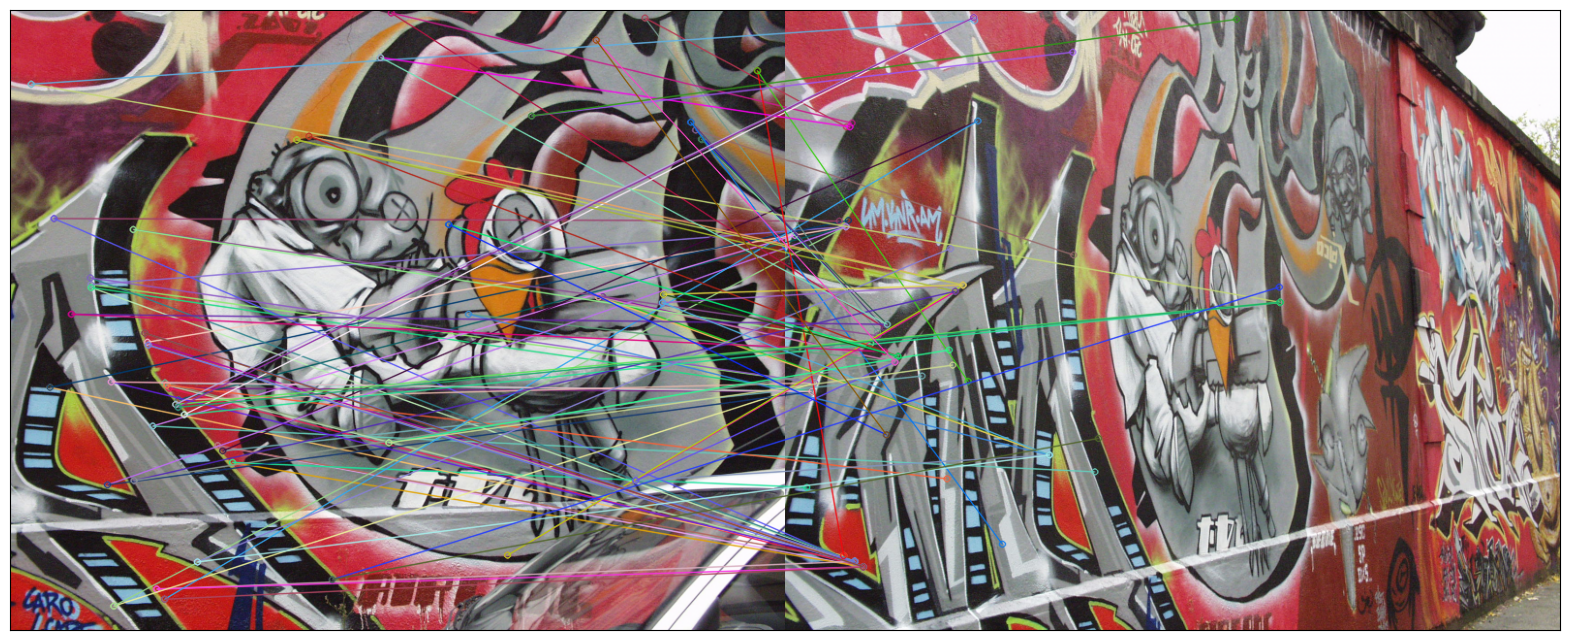

In [1]:
import cv2  as cv
import numpy as np
import matplotlib.pyplot as plt


img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()
bf = cv.BFMatcher()

key1, des1 = sift.detectAndCompute(img1_gray, None)
key5, des5 = sift.detectAndCompute(img5_gray, None)

matches = bf.knnMatch(des1, des5, k=2)
print(matches[:5])
matches = sorted(matches, key=lambda x:x[0].distance)

out_img = cv.drawMatchesKnn(img1, key1, img5, key5, matches[:50], img5, flags=2) #only draw bets 50 matches

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])

plt.show()




In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def findFeatures(img):
    sift = cv.SIFT_create()
    key, des = sift.detectAndCompute(img, None)
    return key, des

def findMatches(des1, des5):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des5, k=2)
    return matches


def calHomography(sample):
    A = []
    for i in range(len(sample)):
        x1, y1, x2, y2 = sample[i, 0], sample[i, 1], sample[i, 2], sample[i, 3]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

    A = np.matrix(A)
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1/H.item(8))*H
    return H

def calDistance(H, correspondence):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


def RANSAC(corres,threshold):
    max_inliers = []
    homography = []

    for i in range(int(np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**4))):
        corr1 = corres[np.random.randint(0, len(corres))]
        corr2 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((corr1, corr2))
        corr3 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr3))
        corr4 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr4))
        
        
        h = calHomography(sample)
        inliers = []
        
        for j in range(len(corres)):
            distance = calDistance(h, corres[j])
            if distance < threshold:
                inliers.append(corres[j])
        

        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            
            homography = h
        
    return homography,inliers

img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')

estimated_threshold = 100

correspondence = []
key1, des1 = findFeatures(img1)
key5, des5 = findFeatures(img5)
keypoints = [key1, key5]
matches = findMatches(des1, des5)

for match in matches:
    (x1, y1) = keypoints[0][match[0].queryIdx].pt
    (x2, y2) = keypoints[1][match[0].trainIdx].pt
    correspondence.append([x1, y1, x2, y2])

corres = np.matrix(correspondence)
H,inliers =RANSAC(corres,estimated_threshold)
print(H)

print('no of inliers',len(inliers))

[[ 1.41134525e+00 -1.47750239e+00  4.06449017e+02]
 [ 9.41149672e-01 -1.00039985e+00  2.83684743e+02]
 [ 3.34927884e-03 -3.55848470e-03  1.00000000e+00]]
no of inliers 191


(640, 800, 3)
(640, 800, 3)


(-0.5, 799.5, 639.5, -0.5)

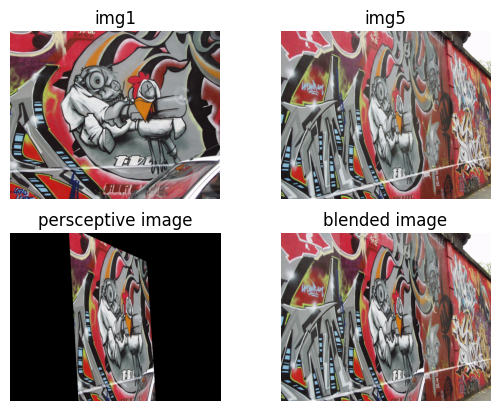

In [5]:
img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')

plt.subplot(2,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5')
plt.axis('off')
print(img1.shape)
print(img5.shape)

h_text = open('H1to5p','r')


#coverting h_text to homography matrix
original_H = []
for line in h_text:
    line = line.strip()
    line = line.split()
    line = [float(i) for i in line]
    original_H.append(line)


original_H = np.matrix(original_H)

image_perspective = cv.warpPerspective(img1, original_H, (img5.shape[1], img5.shape[0]))
plt.subplot(2,2,3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('persceptive image')
plt.axis('off')

threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)
#dst = cv.add(image_perspective, img5_bg)
plt.subplot(2,2,4)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB)) 
plt.title('blended image')
plt.axis('off') 

